# SYDE 522 Project

[description here]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from brian2 import *

### J. Etxaniz & I. Urbina's Implementation

Their project: https://julenetxaniz.eus/en/project/spiking-neural-network/

Original publication it was based off of: https://www.izhikevich.org/publications/spikes.htm

In [ ]:
# Define default values for the parameters
def model(a=0.02, b=0.2, c=-65, d=2, fI='int(t>100*ms)*10', V=-65, tau=0.25, duration=1000):
    
    # Parameters:
        # a: describes the time scale of the recovery variable u.
        # b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
        #    of the membrane potential v.
        # c: describes the after-spike reset value of the membrane potential v.
        # d: describes after-spike reset of the recovery variable u.
        # fI: function that defines the value of I through time.
        # V: initial value of the membrane potential.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    duration = duration*ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    # Simulation
    # Add int(t>duration/10) to make v and u constant at the start when I=0
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = int(t>duration/10)*tau*a*(b*v-u) : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Set initial values of v and u
    G.v = V
    G.u = b*V
    
    # Create a monitor to record v, u and I values
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    # Set I value every 1*ms with the parameter function fI
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    # Run the simulation for duration time
    run(duration)
   
    # Plotting
    plot(M.t/ms, M.v[0], label='v')
    plot(M.t/ms, M.u[0], label='u')
    plot(M.t/ms, M.I[0], label='I')
    axhline(30, ls='-', c='C3', lw=2, label='v=30')
    xlabel('Time (ms)')
    ylabel('v, u, I')
    legend()


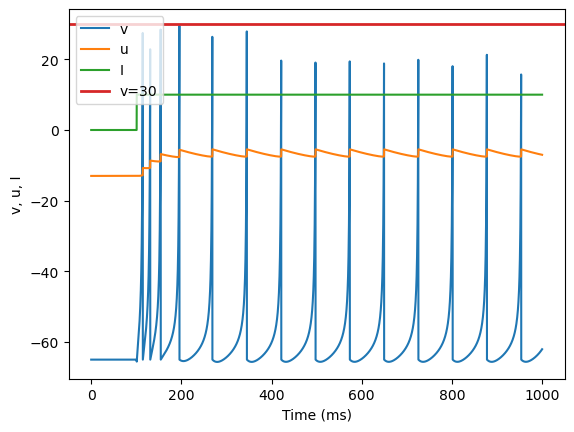

In [4]:
model()

### Simulation

Originally proproposed here: https://www.izhikevich.org/publications/net.m (1000 neurons, 800 excitatory and 200 inhibitory, run for 1000ms but doesn't use strict types - instead values calculated randomly to resemble real variability)

In [16]:
def simulation(Ne=800, Ni=200, tau=1, duration=1000):
    
    # Parameters:
        # Ne: excitatory neurons quantity.
        # Ni: inhibitory neurons quantity.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
    
    defaultclock.dt = 0.1*ms
    tau = tau/ms
    duration = duration*ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    # Independent variables:
    #    1) I: represents the input current.
    #    2) v: represents the membrane potential of the neuron.
    #    3) u: represents a membrane recovery variable which provides negative feedback to v. This feedback
    #          is caused due to activation of K+ ionic currents and inactivation of Na+ ionic currents.
    #    4) a: describes the time scale of the recovery variable u.
    #    5) b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
    #          of the membrane potential v.
    #    6) c: describes the after-spike reset value of the membrane potential v.
    #    7) d: describes after-spike reset of the recovery variable u.
    
    eqs = '''
    dv/dt = tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = tau*a*(b*v-u) : 1
    I : 1
    a : 1
    b : 1
    c : 1
    d : 1
    '''
    
    # Excitatory neurons group network. Quantity of Ne (800)
    Ge = NeuronGroup(Ne, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Inhibitory neurons group network. Quantity of Ni (200)
    Gi = NeuronGroup(Ni, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    
    # Initial values of excitatory neurons parameters a, b, c, d, v and u 
    Ge.a = 0.02
    Ge.b = 0.2
    Ge.c = '-65+15*rand()**2'
    Ge.d = '8-6*rand()**2'
    Ge.v = -65
    Ge.u = Ge.b*-65
    # Initial values of inhibitory neurons parameters a, b, c, d, v and u 
    Gi.a = '0.02+0.08*rand()'
    Gi.b = '0.25-0.05*rand()'
    Gi.c = -65
    Gi.d = 2
    Gi.v = -65
    Gi.u = Gi.b*-65
    
    # Creating synaptical connections between neurons. 4 types of connections:
    #    1) See: a group of excitatory neurons where connections are given by excitatory-excitatory relations
    #    2) Sei: a group of excitatory and inhibitory neurons where connections are given by 
    #             excitatory->inhibitory relations.
    #    3) Sie: a group of excitatory and inhibitory neurons where connections are given by 
    #             inhibitory->excitatory relations.
    #    4) Sii: a group of inhibitory neurons where connections are given by inhibitory-inhibitory relations.
    
    See = Synapses(Ge, Ge, 'w : 1', on_pre='I_post += w')
    See.connect()
    See.w = '0.5*rand()'
    
    Sei = Synapses(Ge, Gi, 'w : 1', on_pre='I_post += w')
    Sei.connect()
    Sei.w = '0.5*rand()'
    
    Sie = Synapses(Gi, Ge, 'w : 1', on_pre='I_post += w')
    Sie.connect()
    Sie.w = '-rand()'
    
    Sii = Synapses(Gi, Gi, 'w : 1', on_pre='I_post += w')
    Sii.connect()
    Sii.w = '-rand()'
    
    # Creating a monitor to measure the values of the first neuron
    Me = StateMonitor(Ge, ('v', 'u', 'I'), record=0)
   
    # Creating monitors that records each NeuronGroup spikes times
    Se = SpikeMonitor(Ge)
    Si = SpikeMonitor(Gi)
    
    # Compute I randomly with normal distribution in each time step
    Ge.run_regularly('I = 5*randn()', dt=tau*ms**2)
    Gi.run_regularly('I = 2*randn()', dt=tau*ms**2)

    # Run the model for a time defined by duration variable
    run(duration)
   
    # Plotting
    figure(figsize=(20, 20))
    # Plot numbers of spiking neurons
    subplot(2,1,1)
    plot(Se.t/ms, Se.i, '.k', ms=3, c='C0', label='Excitatory')
    plot(Si.t/ms, Si.i+Ne, '.k', ms=3, c='C1', label='Inhibitory')
    axhline(Ne, ls='-', c='C2', lw=2, label='Ne')
    xlim(0, duration/ms)
    ylim(0, Ne+Ni)
    xlabel('Time (ms)')
    ylabel('Neuron number')
    title('Numbers of the spiking neurons')
    legend()
    # Plot spikes of first neuron
    subplot(2,1,2)
    plot(Me.t/ms, Me.v[0], label='v')
    plot(Me.t/ms, Me.u[0], label='u')
    plot(Me.t/ms, Me.I[0], label='I')
    axhline(30, ls='-', c='C3', lw=2, label='v=30')
    xlim(0, duration/ms)
    xlabel('Time (ms)')
    ylabel('v, u, I')
    title('v, u and I values of the first neuron')
    legend()


WARNING    C:\Users\yingy\AppData\Local\Temp\ipykernel_2132\1034245416.py:101: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plot(Se.t/ms, Se.i, '.k', ms=3, c='C0', label='Excitatory')
 [py.warnings]
WARNING    C:\Users\yingy\AppData\Local\Temp\ipykernel_2132\1034245416.py:102: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plot(Si.t/ms, Si.i+Ne, '.k', ms=3, c='C1', label='Inhibitory')
 [py.warnings]


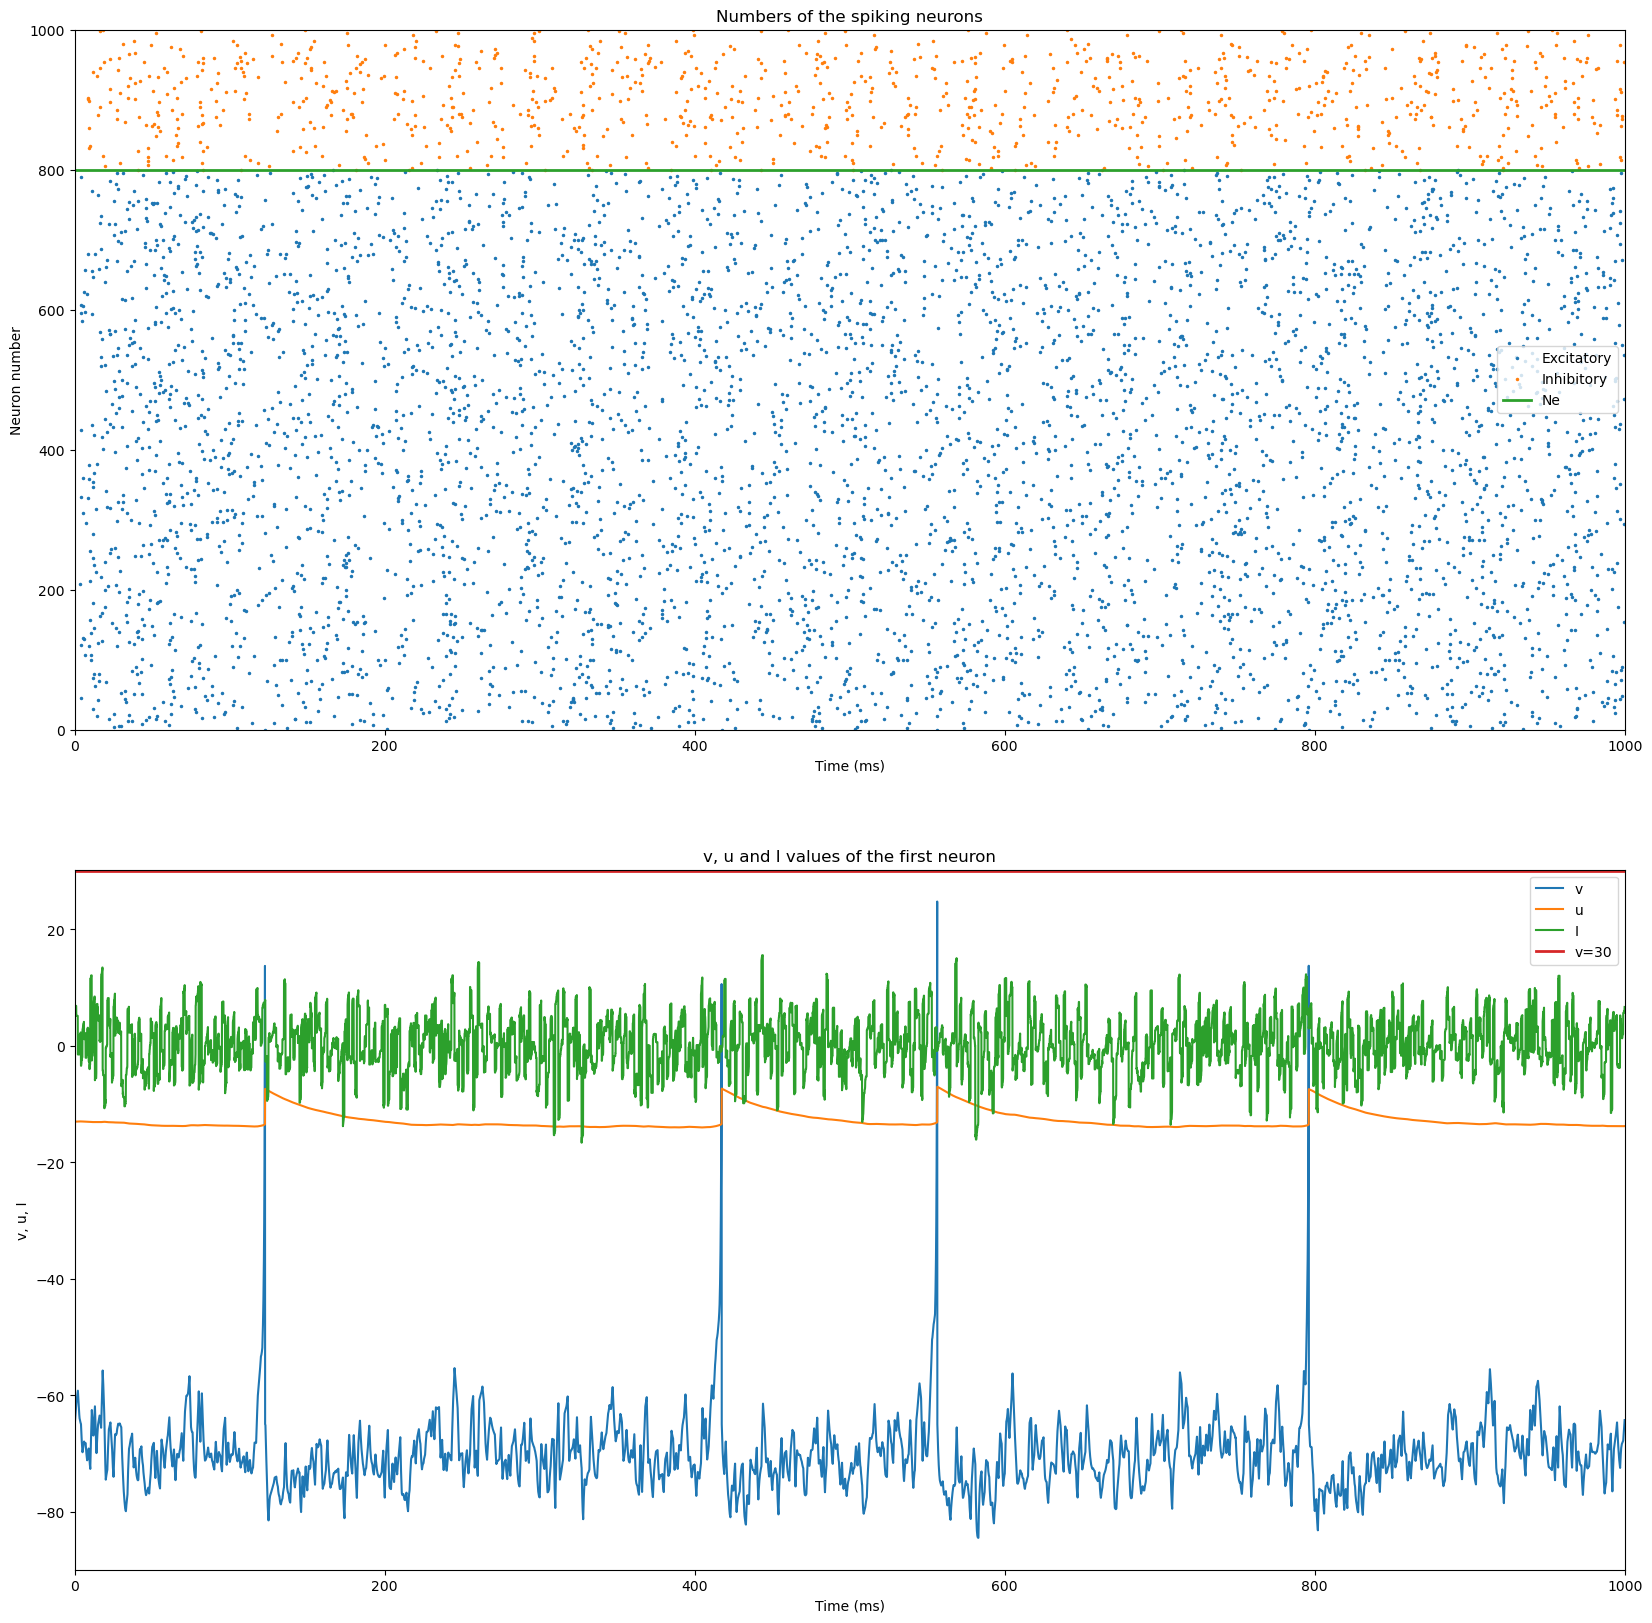

In [18]:
simulation()

### Modifying the IZH Model for Trimodal Spiking

In [95]:
# functions for plotting
def plot_output_colored(t, v, u, I):
    fig, axes = plt.subplots(4, sharey=True, figsize=(12, 12))
    fig.tight_layout()
    
    axes[0].plot()
    axes[0].plot(t, v, label='v')
    axes[0].plot(t, u, label='u')
    axes[0].plot(t, I, label='I')
    axes[0].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('v, u, I')
    axes[0].set_title('Trimodal')
    axes[0].legend()
    
    axes[1].plot(t, v, label='v')
    axes[1].plot(t, u, label='u')
    axes[1].plot(t, I, label='I')
    axes[1].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[1].set_xlim([1000, 2000])
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('v, u, I')
    axes[1].set_title('Tonic')
    axes[1].legend()
    
    axes[2].plot(t, v, label='v')
    axes[2].plot(t, u, label='u')
    axes[2].plot(t, I, label='I')
    axes[2].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[2].set_xlim([7000, 8000])
    axes[2].set_xlabel('Time (ms)')
    axes[2].set_ylabel('v, u, I')
    axes[2].set_title('Burst')
    axes[2].legend()
    
    axes[3].plot(t, v, label='v')
    axes[3].plot(t, u, label='u')
    axes[3].plot(t, I, label='I')
    axes[3].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[3].set_xlim([13000, 14000])
    axes[3].set_xlabel('Time (ms)')
    axes[3].set_ylabel('v, u, I')
    axes[3].set_title('Quiescent')
    axes[3].legend()
    
    plt.show
    
    
def plot_output(t, v, u):
    fig, axes = plt.subplots(4, sharey=True, figsize=(12, 12))
    fig.tight_layout()
    
    axes[0].plot()
    axes[0].plot(t, v, 'k-', label='v')
    axes[0].plot(t, u, 'k:', label='u')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('v, u')
    axes[0].set_title('Trimodal')
    axes[0].legend()
    
    axes[1].plot(t, v, 'k-', label='v')
    axes[1].plot(t, u, 'k:', label='u')
    axes[1].set_xlim([1000, 2000])
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('v, u')
    axes[1].set_title('Tonic')
    axes[1].legend()
    
    axes[2].plot(t, v, 'k-', label='v')
    axes[2].plot(t, u, 'k:', label='u')
    axes[2].set_xlim([7000, 8000])
    axes[2].set_xlabel('Time (ms)')
    axes[2].set_ylabel('v, u')
    axes[2].set_title('Burst')
    axes[2].legend()
    
    axes[3].plot(t, v, 'k-', label='v')
    axes[3].plot(t, u, 'k:', label='u')
    axes[3].set_xlim([13000, 14000])
    axes[3].set_xlabel('Time (ms)')
    axes[3].set_ylabel('v, u')
    axes[3].set_title('Quiescent')
    axes[3].legend()
    
    plt.show

In [99]:
# izh model for trimodel spike pattern
def IZH(
    fI='int(t>100*ms)*10', 
    V=-65, 
    tau=0.25, 
    duration_t=5000,
    duration_b=7000,
    duration_q=8000,
    plot_colored = True,
):
    
    # Parameters:
        # a: describes the time scale of the recovery variable u.
        # b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
        #    of the membrane potential v.
        # c: describes the after-spike reset value of the membrane potential v.
        # d: describes after-spike reset of the recovery variable u.
        # fI: function that defines the value of I through time.
        # V: initial value of the membrane potential.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    # Simulation
    # Add int(t>duration/10) to make v and u constant at the start when I=0
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = int(t>duration/10)*tau*a*(b*v-u) : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Set initial values of v and u
    G.v = V
    G.u = 0.2*V
    
    # Create a monitor to record v, u and I values
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    # Set I value every 1*ms with the parameter function fI
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    # Run the simulation for duration time
    print('Running tonic period...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5 # ISI_tonic = 30ms
    duration = duration_t*ms
    run(duration)
    
    print('Running burst period...')
    a = 0.035
    b = 0.3
    c = -50
    d = 2.4 # duration_burst = 50 to 100ms, rest_burst = 10ms
    duration = duration_b*ms
    run(duration)
    
    print('Running quiescent period...')
    a = 0
    b = 0
    c = -65
    d = 2
    duration = duration_q*ms
    run(duration)
    
    print('Running tonic period (again)...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5 # ISI_tonic = 30ms
    duration = 500*ms
    run(duration)
   
    # Plotting
    print('Creating plot.')
    if plot_colored:
        plot_output_colored(M.t/ms, M.v[0], M.u[0], M.I[0])
    else:
        plot_output(M.t/ms, M.v[0], M.u[0])
    


Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.


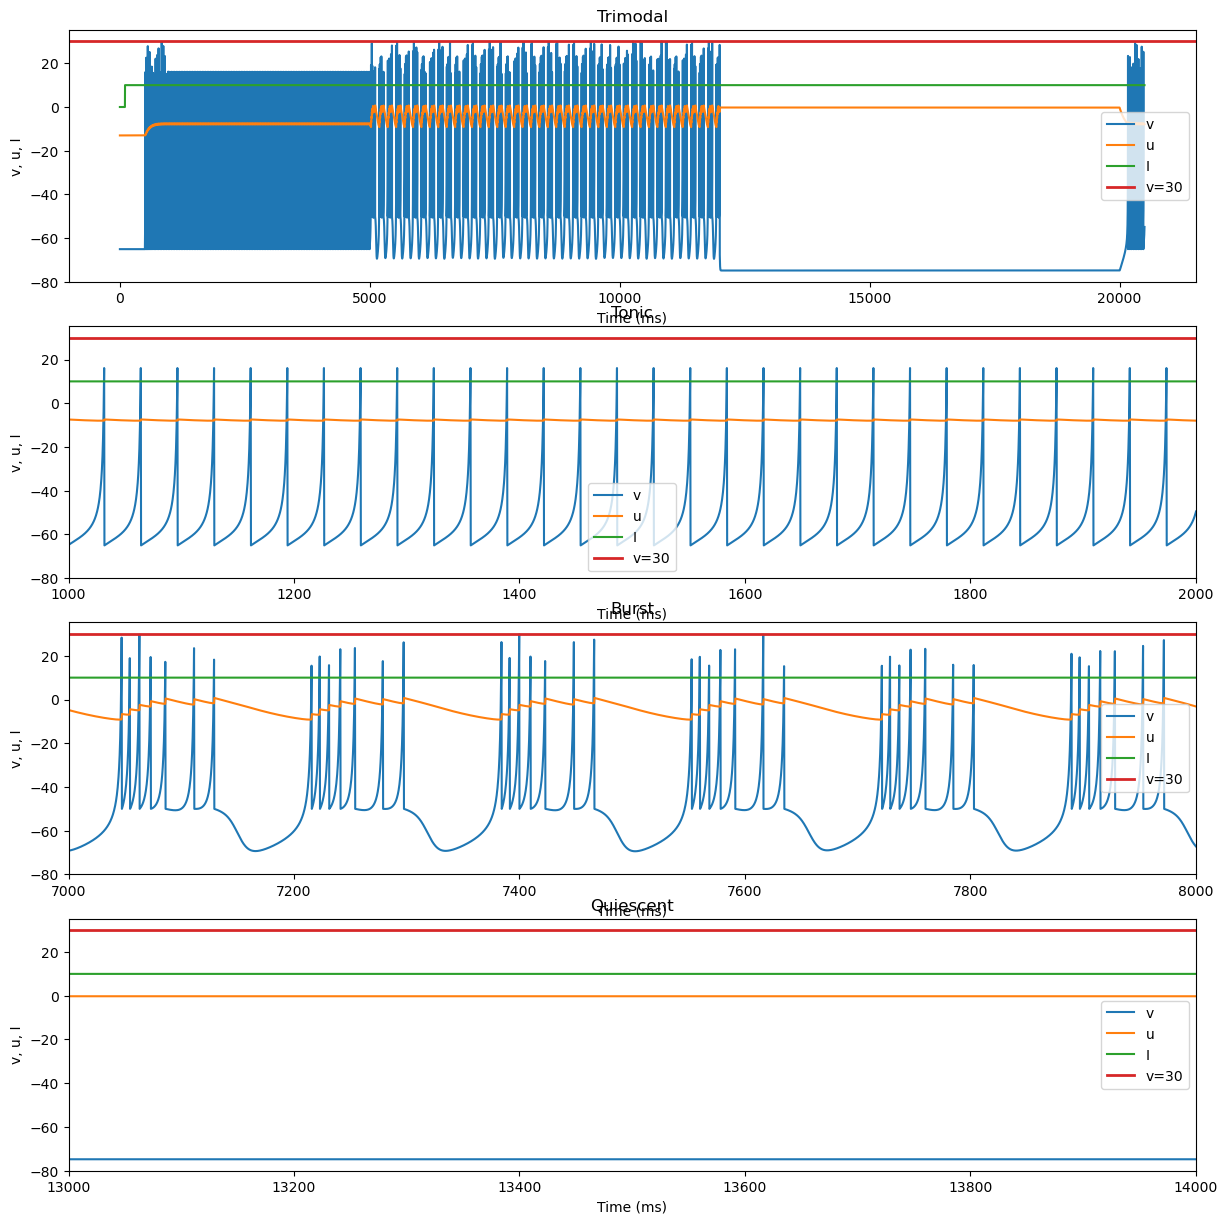

In [100]:
IZH()

### Alcohol Inhibition

In [ ]:
# izh model that implements alcohol inhibition dynamics (TODO)
def IZH_inh(
    fI='int(t>100*ms)*10', 
    V=-65, 
    tau=0.25, 
    duration_t=5000,
    duration_b=7000,
    duration_q=8000,
    plot_colored = False #True,
):
    
    # Parameters:
        # a: describes the time scale of the recovery variable u.
        # b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
        #    of the membrane potential v.
        # c: describes the after-spike reset value of the membrane potential v.
        # d: describes after-spike reset of the recovery variable u.
        # fI: function that defines the value of I through time.
        # V: initial value of the membrane potential.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    # Simulation
    # Add int(t>duration/10) to make v and u constant at the start when I=0
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = int(t>duration/10)*tau*a*(b*v-u) : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Set initial values of v and u
    G.v = V
    G.u = 0.2*V
    
    # Create a monitor to record v, u and I values
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    # Set I value every 1*ms with the parameter function fI
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    # Run the simulation for duration time
    print('Running tonic period...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5 # ISI_tonic = 30ms
    duration = duration_t*ms
    run(duration)
    
    print('Running burst period...')
    a = 0.035
    b = 0.3
    c = -50
    d = 2.4 # duration_burst = 50 to 100ms, rest_burst = 10ms
    duration = duration_b*ms
    run(duration)
    
    print('Running quiescent period...')
    a = 0
    b = 0
    c = -65
    d = 2
    duration = duration_q*ms
    run(duration)
    
    print('Running tonic period (again)...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5 # ISI_tonic = 30ms
    duration = 500*ms
    run(duration)
   
    # Plotting
    print('Creating plot.')
    if plot_colored:
        plot_output_colored(M.t/ms, M.v[0], M.u[0], M.I[0])
    else:
        plot_output(M.t/ms, M.v[0], M.u[0])
    
